## Magnificent 7 Backtesting

#### Background
As an analyst, you are tasked with creating a backtesting system to evaluate a group of stocks
known as the "Magnificent 7": Microsoft (MSFT), Apple (AAPL), Nvidia (NVDA), Amazon
(AMZN), Google (GOOG), Meta (META), and Tesla (TSLA) in the U.S. stock market.

#### Import Libraries

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns

In [ ]:
tickerData = yf.Ticker('META')
df_meta = tickerData.history(interval='1d', start='1981-1-1', end='2023-12-31' ,auto_adjust=True)
df_meta = df_meta.asfreq(pd.infer_freq(df_meta.index))
df_meta.dropna(inplace=True)
df_meta.head()



In [ ]:
def RSIcalc(ticker_df): #calculate RSI using wilder's smoothing for a steadier, longer-term approach.
    ticker_df['price change'] = ticker_df['Close'].diff(1)
    ticker_df['Upmove'] = ticker_df['price change'].apply(lambda x: x if x > 0 else 0) # positive values remain else take 0
    ticker_df['Downmove'] = ticker_df['price change'].apply(lambda x: abs(x) if x < 0 else 0) # negative values remain else take 0
    ticker_df['avg Up'] = ticker_df['Upmove'].ewm(span=27).mean() #wilder's smoothing for N=14
    ticker_df['avg Down'] = ticker_df['Downmove'].ewm(span=27).mean()
    ticker_df.dropna(inplace=True)
    ticker_df['RS'] = ticker_df['avg Up']/ticker_df['avg Down']
    ticker_df['RSI'] = ticker_df['RS'].apply(lambda x: 100.0 - (100.0 / (1.0 + x)))
    
    return ticker_df[13:]

meta = RSIcalc(df_meta)
meta
    

In [ ]:
# Plot RSI
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(211)
ax1.plot(meta.index, meta['Close'], color='lightgray')
ax1.set_title("Adjusted Close Price", color='white')

ax1.grid(True, color = '#555555')
ax1.set_axisbelow(True)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(meta.index, meta['RSI'], color='lightgrey') # combined.index=datetime
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')
ax2.axhline(25, linestyle='--', alpha=0.5, color='#ffaa00')
ax2.axhline(75, linestyle='--', alpha=0.5, color='#ffaa00')

ax2.set_title("RSI Value")
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor('black')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
plt.show()

In [ ]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0 # state control: bought = 1, sold = -1 , holding = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 25  and rsi[i] < 25: # Buy Condition: RSI Crossover
            if signal != 1: # signal = 0 or -1 meaning we are holding shares or have just sold recently
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal) # To buy stock as buy condition is satisfied
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 75 and rsi[i] > 75: # Sell Condition: RSI Crossover
            if signal != -1: # signal not -1 to check that we are holding shares/we have not just sold as -1 means just sold
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else: # if signal = -1 means we just sold and cannot sell again before buying
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

buy_price, sell_price, rsi_signal = implement_rsi_strategy(meta['Close'], meta['RSI'])

In [ ]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

In [ ]:
# Plot RSI
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(211)
ax1.plot(meta.index, meta['Close'], color='lightgray')
ax1.plot(meta.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(meta.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title("Adjusted Close Price", color='white')

ax1.grid(True, color = '#555555')
ax1.set_axisbelow(True)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(meta.index, meta['RSI'], color='lightgrey') # combined.index=datetime
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')
ax2.axhline(25, linestyle='--', alpha=0.5, color='#ffaa00')
ax2.axhline(75, linestyle='--', alpha=0.5, color='#ffaa00')

ax2.set_title("RSI Value")
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor('black')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
plt.show()

In [ ]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(meta['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = meta['RSI']
close_price = meta['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(meta.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(meta.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

In [ ]:
strategy.loc[strategy['rsi_signal'] == 1]

In [ ]:
strategy.loc[strategy['rsi_signal'] == -1]

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import List, Dict
import matplotlib.pyplot as plt

class MagnificentSevenBacktest:
    def __init__(self, 
                 stocks: List[str], 
                 start_date: str = '1981-01-01', 
                 end_date: str = '2023-12-31',
                 initial_capital: float = 1_000_000,
                 risk_free_rate: float = 0.02,
                 commission_rate: float = 0.001,
                 slippage_rate: float = 0.0002,
                 min_shares: int = 10,
                 max_portfolio_weight: float = 0.3):
        """
        Initialize the backtesting system for Magnificent 7 stocks
        
        Parameters:
        - stocks: List of stock tickers
        - start_date: Global start date
        - end_date: Global end date
        - initial_capital: Starting portfolio value
        - risk_free_rate: Annual risk-free rate
        - commission_rate: Transaction commission percentage
        - slippage_rate: Price slippage percentage
        - min_shares: Minimum number of shares per trade
        - max_portfolio_weight: Maximum weight for a single stock
        """
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.risk_free_rate = risk_free_rate
        self.commission_rate = commission_rate
        self.slippage_rate = slippage_rate
        self.min_shares = min_shares
        self.max_portfolio_weight = max_portfolio_weight
        
        # Fetch IPO dates and adjust start date for each stock
        self.stock_start_dates = self._get_ipo_dates()
        
        # Initialize data storage
        self.price_data = self._fetch_stock_data()
        self.rsi_data = self._calculate_wilder_rsi()
        
        # Debugging RSI data
        print("\nRSI Data Statistics:")
        for stock in self.stocks:
            print(f"{stock} RSI:")
            print("Min:", self.rsi_data[stock].min())
            print("Max:", self.rsi_data[stock].max())
            print("Mean:", self.rsi_data[stock].mean())
            print("Number of non-zero values:", (self.rsi_data[stock] != 0).sum())
        
        # Debugging lines
        print("Stock Start Dates:", self.stock_start_dates)
        print("Price Data Shape:", self.price_data.shape)
        print("Price Data Columns:", self.price_data.columns)
        print("RSI Data Shape:", self.rsi_data.shape)
        print("First few rows of Price Data:\n", self.price_data.head())
        print("First few rows of RSI Data:\n", self.rsi_data.head())
        
    def _get_ipo_dates(self) -> Dict[str, str]:
        """
        Get IPO dates for each stock with more robust error handling
        
        Returns:
        - Dictionary of stock IPO dates
        """
        ipo_dates = {}
        global_start = pd.to_datetime(self.start_date).tz_localize(None)
        global_end = pd.to_datetime(self.end_date).tz_localize(None)
        
        for stock in self.stocks:
            ticker = yf.Ticker(stock)
            try:
                # Fetch max historical data
                hist = ticker.history(period="max")
                
                if hist.empty:
                    print(f"Warning: No historical data found for {stock}")
                    ipo_dates[stock] = self.start_date
                    continue
                
                # Remove timezone information and convert to datetime
                ipo_date = pd.to_datetime(hist.index[0]).tz_localize(None)
                
                # Ensure IPO date is within the specified date range
                ipo_date = max(min(ipo_date, global_end), global_start)
                
                ipo_dates[stock] = ipo_date.strftime('%Y-%m-%d')
            except Exception as e:
                print(f"Error fetching IPO date for {stock}: {e}")
                ipo_dates[stock] = self.start_date
        
        return ipo_dates
    
    def _fetch_stock_data(self) -> pd.DataFrame:
        """
        Fetch historical stock price data from Yahoo Finance
        Ensuring consistent index across all stocks
        
        Returns:
        - DataFrame with adjusted close prices for all stocks
        """
        data = {}
        common_index = None
        
        for stock in self.stocks:
            start_date = self.stock_start_dates[stock]
            ticker = yf.Ticker(stock)
            
            try:
                # Fetch historical data
                hist = ticker.history(start=start_date, end=self.end_date, auto_adjust=True)
                
                if hist.empty:
                    print(f"Warning: No data found for {stock} from {start_date}")
                    continue
                
                # Store close prices
                data[stock] = hist['Close']
                
                # Track the most comprehensive index
                if common_index is None:
                    common_index = hist.index
                else:
                    common_index = common_index.union(hist.index)
            
            except Exception as e:
                print(f"Error fetching data for {stock}: {e}")
        
        # Create DataFrame with a consistent index
        price_data = pd.DataFrame(index=common_index)
        
        for stock, prices in data.items():
            price_data[stock] = prices.reindex(common_index)
        
        # Forward fill missing values to handle different IPO dates
        price_data.fillna(method='ffill', inplace=True)
        
        # Drop rows with all NaN values
        price_data.dropna(how='all', inplace=True)
        
        return price_data
    
    def _calculate_wilder_rsi(self, window: int = 27) -> pd.DataFrame: 
        """
        Calculate RSI using Wilder's smoothing method
        
        Parameters:
        - window: RSI calculation period
        
        Returns:
        - DataFrame with RSI values for all stocks
        """
        def wilder_rsi(prices):
            """
            Calculate RSI using Wilder's smoothing for a steadier, longer-term approach
            
            Parameters:
            - prices: Price series
            
            Returns:
            - RSI series
            """
            # Ensure no NaN values at the start
            prices = prices.dropna()
            
            if len(prices) < window:
                return pd.Series(index=prices.index, data=np.nan)
            
            # Calculate price changes
            delta = prices.diff()
            
            # Separate positive and negative moves
            Upmove = delta.apply(lambda x: x if x > 0 else 0)
            Downmove = delta.apply(lambda x: abs(x) if x < 0 else 0)
            
            # Wilder's smoothing 
            avg_Up = Upmove.ewm(span=window, adjust=False).mean()
            avg_Down = Downmove.ewm(span=window, adjust=False).mean()
            
            # Calculate Relative Strength (RS)
            rs = avg_Up / avg_Down
            
            # Calculate RSI
            rsi = 100.0 - (100.0 / (1.0 + rs))
            
            return rsi
        
        # Calculate RSI for each stock
        rsi_data = {}
        for stock in self.stocks:
            stock_prices = self.price_data[stock]
            rsi_data[stock] = wilder_rsi(stock_prices)
        
        # Create DataFrame with a consistent index
        rsi_df = pd.DataFrame(rsi_data)
        
        # Fill NaN values
        rsi_df.fillna(method='ffill', inplace=True)
        rsi_df.dropna(how='all', inplace=True)
        
        return rsi_df

    

    def generate_signals(self) -> pd.DataFrame:
        """
        Generate buy/sell signals based on RSI with improved logic
        
        Returns:
        - DataFrame with trading signals
        """
        # Align RSI and price data
        signals = pd.DataFrame(0, index=self.rsi_data.index, columns=self.stocks)
        
        for stock in self.stocks:
            # Previous and current RSI
            prev_rsi = self.rsi_data[stock].shift(1)
            curr_rsi = self.rsi_data[stock]
            
            # Debugging print statements
            print(f"\nDebugging {stock} RSI:")
            print("Previous RSI sample:", prev_rsi.head())
            print("Current RSI sample:", curr_rsi.head())
            
            # Refined buy signal: RSI drops below 25 from above 25
            buy_signal = (prev_rsi > 25) & (curr_rsi <= 25)
            
            # Refined sell signal: RSI rises above 75 from below 75
            sell_signal = (prev_rsi < 75) & (curr_rsi >= 75)
            
            # Assign signals with careful tracking
            signals.loc[buy_signal, stock] = 1   # Buy
            signals.loc[sell_signal, stock] = -1  # Sell
        
        # Debugging print
        print("\nSignals summary:")
        print(signals.sum())
        
        return signals
    
    def _calculate_max_drawdown(self, portfolio_value):
        """
        Calculate maximum drawdown
        
        Parameters:
        - portfolio_value: List of portfolio values
        
        Returns:
        - Maximum drawdown percentage
        """
        peaks = np.maximum.accumulate(portfolio_value)
        drawdowns = (portfolio_value - peaks) / peaks
        return max(drawdowns)
    
    def detailed_signal_analysis(self):
        """
        Comprehensive analysis of signal generation
        """
        signals = self.generate_signals()
        
        print("\nDetailed Signal Analysis:")
        for stock in self.stocks:
            print(f"\n{stock} Analysis:")
            stock_rsi = self.rsi_data[stock]
            
            # Find all potential signal points
            buy_candidates = stock_rsi[stock_rsi <= 25]
            sell_candidates = stock_rsi[stock_rsi >= 75]
            
            print("Buy Candidate Points:")
            print(buy_candidates)
            print("\nSell Candidate Points:")
            print(sell_candidates)
            
            # Count of signals
            buy_signals = signals[signals[stock] == 1]
            sell_signals = signals[signals[stock] == -1]
            
            print(f"Buy Signals Count: {len(buy_signals)}")
            print(f"Sell Signals Count: {len(sell_signals)}")

    def backtest(self):
        """
        Perform backtesting with robust portfolio management and metrics calculation
        
        Returns:
        - Performance metrics dictionary
        """
        signals = self.generate_signals()
        prices = self.price_data
        
        # Initialize portfolio tracking
        portfolio_value = [self.initial_capital]
        positions = pd.DataFrame(0, index=signals.index, columns=self.stocks)
        cash = [self.initial_capital]
        trades = []
        
        # Debugging print to check signals
        print("Total signals:", signals.sum())
        
        for date in signals.index[1:]:
            prev_date = signals.index[signals.index.get_loc(date) - 1]
            current_portfolio_value = portfolio_value[-1]
            current_cash = cash[-1]
            
            # Determine which stocks need action
            buy_signals = signals.loc[date] == 1
            sell_signals = signals.loc[date] == -1
            
            # Calculate equal weight per stock meeting signal criteria
            active_stocks = signals.loc[date][buy_signals | sell_signals].index
            weight_per_stock = (self.max_portfolio_weight / len(active_stocks)) if len(active_stocks) > 0 else 0
            
            for stock in active_stocks:
                price = prices.loc[date, stock]
                prev_price = prices.loc[prev_date, stock]
                
                # Buy logic
                if signals.loc[date, stock] == 1:
                    target_value = current_portfolio_value * weight_per_stock
                    shares_to_buy = max(self.min_shares, int(target_value / price))
                    
                    total_cost = shares_to_buy * price * (1 + self.commission_rate + self.slippage_rate)
                    
                    if total_cost <= current_cash and shares_to_buy > 0:
                        positions.loc[date, stock] = shares_to_buy
                        current_cash -= total_cost
                        trades.append({
                            'date': date, 
                            'stock': stock, 
                            'action': 'BUY', 
                            'shares': shares_to_buy, 
                            'price': price
                        })
                
                # Sell logic
                elif signals.loc[date, stock] == -1:
                    shares_to_sell = positions.loc[prev_date, stock]
                    if shares_to_sell > 0:
                        total_sale = shares_to_sell * price * (1 - self.commission_rate - self.slippage_rate)
                        current_cash += total_sale
                        positions.loc[date, stock] = 0
                        trades.append({
                            'date': date, 
                            'stock': stock, 
                            'action': 'SELL', 
                            'shares': shares_to_sell, 
                            'price': price
                        })
            
            # Calculate portfolio value
            portfolio_stock_value = (prices.loc[date] * positions.loc[date]).sum()
            total_value = portfolio_stock_value + current_cash
            portfolio_value.append(total_value)
            cash.append(current_cash)
        
        # Performance metrics calculation with robust error handling
        if len(portfolio_value) <= 1:
            return {
                'Total Return': 0,
                'Annual Return': 0,
                'Annual Volatility': 0,
                'Maximum Drawdown': 0,
                'Sharpe Ratio': 0,
                'Sortino Ratio': 0,
                'Total Trades': 0,
                'Average Trade Return': 0,
                'Win Rate': 0,
                'Expectancy': 0
            }
        
        returns = pd.Series(portfolio_value).pct_change().dropna()
        annual_return = returns.mean() * 252
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Enhanced trade performance tracking
        buy_trades = [trade for trade in trades if trade['action'] == 'BUY']
        sell_trades = [trade for trade in trades if trade['action'] == 'SELL']
        
        trade_profits = []
        for sell_trade in sell_trades:
            matching_buy = next((buy for buy in buy_trades if 
                                buy['stock'] == sell_trade['stock'] and 
                                buy['date'] < sell_trade['date']), None)
            
            if matching_buy:
                trade_profit = (sell_trade['shares'] * sell_trade['price'] - 
                                matching_buy['shares'] * matching_buy['price'])
                trade_profits.append(trade_profit)
        
        # Robust metrics calculation
        trade_profits = np.array(trade_profits)
        if len(trade_profits) > 0:
            win_trades = trade_profits[trade_profits > 0]
            loss_trades = trade_profits[trade_profits <= 0]
            
            win_rate = len(win_trades) / len(trade_profits) * 100
            avg_win = np.mean(win_trades) if len(win_trades) > 0 else 0
            avg_loss = np.mean(loss_trades) if len(loss_trades) > 0 else 0
            
            expectancy = ((win_rate/100 * avg_win) - 
                        ((1 - win_rate/100) * abs(avg_loss))) if avg_loss != 0 else 0
            
            avg_trade_return = np.mean(trade_profits)
        else:
            win_rate = 0
            avg_trade_return = 0
            expectancy = 0
        
        # Sortino and Sharpe calculations
        downside_returns = returns[returns < 0]
        downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        
        sortino_ratio = ((annual_return - self.risk_free_rate) / downside_volatility 
                        if downside_volatility != 0 else 0)
        
        sharpe_ratio = ((annual_return - self.risk_free_rate) / annual_volatility 
                        if annual_volatility != 0 else 0)
        
        max_drawdown = self._calculate_max_drawdown(portfolio_value)
        
        return {
            'Total Return': (portfolio_value[-1] / self.initial_capital - 1) * 100,
            'Annual Return': annual_return * 100,
            'Annual Volatility': annual_volatility * 100,
            'Maximum Drawdown': max_drawdown * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Total Trades': len(trades),
            'Average Trade Return': avg_trade_return,
            'Win Rate': win_rate,
            'Expectancy': expectancy
        }
    
# Execute backtest
stocks = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA']
start_date = '1981-01-01'
end_date = '2023-12-31'

# Run the backtest
backtest = MagnificentSevenBacktest(stocks, start_date=start_date, end_date=end_date)
backtest.detailed_signal_analysis()
results = backtest.backtest()


In [ ]:
# Print results
print("Backtesting Results for Magnificent 7:")
for metric, value in results.items():
    print(f"{metric}: {value}")

### GPT-4o

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(tickers, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
        data[ticker] = stock_data[['Open', 'Close']]
    return data

# Calculate RSI
def calculate_rsi(data, window=14):
    """Compute the Relative Strength Index (RSI) for a stock."""
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Trading signal
def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] >= 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] <= 75), 'Signal'] = -1

    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

# Portfolio simulation
def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and IPO date consideration.
    Parameters:
        data (dict): Dictionary of DataFrames, one per stock, with 'Open', 'Close', and 'Signal'.
        initial_capital (float): Starting capital for the portfolio.
        commission (float): Commission rate per trade.
        slippage (float): Slippage rate per trade.
        min_shares (int): Minimum shares per trade.
    Returns:
        DataFrame: Portfolio performance over time.
    """
    # Prepare portfolio tracking
    portfolio = pd.DataFrame(index=pd.concat([d.index for d in data.values()]).drop_duplicates().sort_values())
    portfolio['Cash'] = initial_capital
    portfolio['Equity'] = 0
    portfolio['Total Value'] = initial_capital
    portfolio['Stock Count'] = 0  # Tracks the number of active stocks in the portfolio

    holdings = {ticker: 0 for ticker in data.keys()}  # Stock holdings (number of shares)

    # Backtesting loop over trading days
    for date in portfolio.index:
        day_value = portfolio.at[date, 'Cash']
        equity_value = 0
        active_stocks = []

        # Process each stock
        for ticker, stock_data in data.items():
            if date not in stock_data.index:  # Skip stocks not active on this date
                continue

            row = stock_data.loc[date]
            signal = row['Signal']
            price = row['Open']
            active_stocks.append(ticker)

            # Execute buy/sell trades based on signal
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                allocation = day_value / len(active_stocks)  # Equal-weight allocation
                quantity = max(min_shares, int(allocation / price))
                trade_cost = price * quantity * (1 + commission + slippage)
                if trade_cost <= day_value:  # Check if sufficient cash is available
                    holdings[ticker] += quantity
                    day_value -= trade_cost

            elif signal == -1 and holdings[ticker] > 0:  # Sell
                quantity = holdings[ticker]
                trade_value = price * quantity * (1 - commission - slippage)
                holdings[ticker] -= quantity
                day_value += trade_value

            # Calculate stock's equity contribution
            equity_value += holdings[ticker] * row['Close']

        # Rebalancing
        total_value = day_value + equity_value
        if active_stocks:
            target_value = total_value / len(active_stocks)
            for ticker in active_stocks:
                current_value = holdings[ticker] * stock_data.loc[date, 'Close']
                if current_value > target_value * 1.3:  # Limit to 30% of portfolio value
                    excess_value = current_value - target_value * 1.3
                    shares_to_sell = int(excess_value / stock_data.loc[date, 'Close'])
                    if shares_to_sell >= min_shares:
                        trade_value = shares_to_sell * stock_data.loc[date, 'Close'] * (1 - commission - slippage)
                        holdings[ticker] -= shares_to_sell
                        day_value += trade_value

        # Update portfolio values
        portfolio.at[date, 'Cash'] = day_value
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)

    return portfolio

# Performance metrics
def calculate_metrics(portfolio):
    """Calculate performance metrics."""
    returns = portfolio['Total Value'].pct_change().dropna()
    total_return = portfolio['Total Value'][-1] / INITIAL_CAPITAL - 1
    annual_return = (1 + total_return) ** (1 / ((END_DATE - START_DATE).days / 365)) - 1
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()

    sortino_ratio = (annual_return - RISK_FREE_RATE) / (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))

    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }
    return metrics

# Main execution
if __name__ == "__main__":
    stock_data = fetch_stock_data(STOCKS, START_DATE, END_DATE)

    for ticker, data in stock_data.items():
        stock_data[ticker] = calculate_rsi(data)
        stock_data[ticker] = generate_signals(stock_data[ticker])

    portfolio = backtest(stock_data, INITIAL_CAPITAL, COMMISSION, SLIPPAGE, MIN_SHARES)
    metrics = calculate_metrics(portfolio)

    print("Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.2%}")

#### Testing

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(stocks, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {} # store each ticker's prices in dictionary
    stock_actions = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data.index = stock_data.index.tz_localize(None)
        stock_actions[stock] = ticker.actions
        # Convert datetime to date
        # stock_data.reset_index(inplace=True)
        # stock_data['Date'] = stock_data['Date'].dt.date
        # stock_data.set_index('Date', inplace=True)
        # stock_data.index = pd.to_datetime(stock_data.index)
        
        # Create ticker:data pairs
        data[stock] = stock_data[['Open', 'Close']]
        
    return data, stock_actions


# Calculate RSI
def calculate_rsi(data, window=14):
    """
    Compute Wilder's Relative Strength Index (RSI) using the `.ewm()` method.
    Parameters:
        data (DataFrame): DataFrame containing a 'Close' column.
        window (int): Look-back period for RSI calculation (default: 14).
    Returns:
        DataFrame: DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0) # postive or zero
    loss = -delta.where(delta < 0, 0) # negative or zero

    # Use `.ewm()` for Wilder's smoothing
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    # data.dropna(subset=['RSI'], inplace=True)
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] > 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] < 75), 'Signal'] = -1

    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and IPO date consideration.
    Parameters:
        data (dict): Dictionary of DataFrames, one per stock, with 'Open', 'Close', and 'Signal'.
        initial_capital (float): Starting capital for the portfolio.
        commission (float): Commission rate per trade.
        slippage (float): Slippage rate per trade.
        min_shares (int): Minimum shares per trade.
    Returns:
        DataFrame: Portfolio performance over time.
    """
    # Print debug information about the indices
    for ticker, ticker_data in data.items():
        print(f"Debug {ticker}:")
        print(f"Index type: {type(ticker_data.index)}")
        print(f"Index dtype: {ticker_data.index.dtype}")
        print(f"First few index values: {ticker_data.index[:5]}")
        print(f"Is '1981-01-21' in index: {pd.Timestamp('1981-01-21') in ticker_data.index}")
        print(f"Exact index check for '1981-01-21': {ticker_data.index.get_loc(pd.Timestamp('1981-01-21')) if pd.Timestamp('1981-01-21') in ticker_data.index else 'Not found'}")
    
    # Prepare portfolio tracking
    common_index = pd.Index([])
    for ticker_data in data.values():
        common_index = common_index.union(ticker_data.index)
    common_index = sorted(common_index)
    portfolio = pd.DataFrame(index=common_index)
    # portfolio = pd.DataFrame(index=data['AAPL'].index) # Create index of entire time horizon
    # portfolio.index = pd.to_datetime(portfolio.index)
    
    portfolio['Cash'] = initial_capital
    portfolio['Equity'] = 0
    portfolio['Total Value'] = initial_capital
    portfolio['Stock Count'] = 0  
    holdings = {ticker: 0 for ticker in data.keys()}  # Stock holdings (number of shares)
    
    # Initialize metrics tracking
    initial_value = initial_capital
    total_trades = 0  # Initialize trade counter
    trade_returns = []
    
    # Backtesting loop over trading days
    for date in portfolio.index:
        # Debug print for problematic date
        print(f"Processing date: {date}, type: {type(date)}")
        day_value = portfolio.at[date, 'Cash'] # Represents the total cash available in the portfolio for trading on that day.
        equity_value = 0
        active_stocks = [] # Tracks the number of active stocks holdings in the portfolio

        # Process each stock for each trading day
        for ticker, stock_data in data.items():
            
            # Verbose error handling
            if date.date() not in stock_data.index.date:
                continue


            row = stock_data.loc[date.date()]
            signal = row['Signal']
            price = row['Open']
            active_stocks.append(ticker) # Stock is considered active (IPOed and available for trading), and its ticker is added to the active_stocks list.

            # Execute buy/sell trades based on signal
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                allocation = day_value / len(active_stocks)  # Equal-weight allocation: total available cash (day_value) is divided equally among all active stocks
                quantity = max(min_shares, int(allocation / price)) # allocation / price: Calculates the maximum number of shares that can be purchased with the allocated cash.
                trade_cost = price * quantity * (1 + commission + slippage) 
                if trade_cost <= day_value:  # Check if sufficient cash is available
                    holdings[ticker] += quantity # Update holding ~ $META:100 shares
                    day_value -= trade_cost # Decrease cash pool
                total_trades += 1
                
                trade_return = (price - buy_price) / buy_price  # Calculate trade return
                trade_returns.append(trade_return)
                
            elif signal == -1 and holdings[ticker] > 0:  # Sell: a sell will only occur if the portfolio holds more than 0 shares (holdings[ticker] > 0).
                quantity = holdings[ticker]
                trade_value = price * quantity * (1 - commission - slippage) # Computes the total proceeds from selling the shares, after deducting commission and slippage costs.
                holdings[ticker] -= quantity # Liquidate ticker position
                day_value += trade_value # Add sale proceeds to cash pool
                total_trades += 1
                
            # Calculate stock's equity contribution
            """
            holdings[ticker]: Represents the number of shares the portfolio currently owns for the given stock (ticker).
            row['Close']: Refers to the closing price of the stock (ticker) on the current trading day (row represents the data for the current date in a loop over dates).
            holdings[ticker] * row['Close']: Calculates the market value of the holdings for this stock on the current day
            """
            equity_value += holdings[ticker] * row['Close']
                
       

            # Rebalancing: Check if rebalancing is required for every date in portfolio.index(entire time horizon)
            """
            Initial Portfolio:
                Total Portfolio Value: $1,000,000.
                Active Stocks: 4 (AAPL, MSFT, GOOG, TSLA).
                Equal Target Value: $250,000.
            """
        total_value = day_value + equity_value # Total portfolio value (cash + equity)
        if active_stocks: # Ensure there are stocks to rebalance
            target_value = total_value / len(active_stocks) # Equal allocation for each stock 
            for ticker in active_stocks:
                current_value = holdings[ticker] * stock_data.loc[date, 'Close'] 
                if current_value > target_value * 1.3:  # Limit to 30% of portfolio value: if stock exceeds 30% of target allocation
                    excess_value = current_value - target_value * 1.3 # The maximum allowable allocation for a single stock (30% over the target value).
                    shares_to_sell = int(excess_value / stock_data.loc[date, 'Close']) # Calculate quantity of shares to sell based on excess_value
                    if shares_to_sell >= min_shares: # Ensure minimum shares are sold
                        trade_value = shares_to_sell * stock_data.loc[date, 'Close'] * (1 - commission - slippage)
                        holdings[ticker] -= shares_to_sell
                        day_value += trade_value

        # Update portfolio values at the end of every day
        portfolio.at[date, 'Cash'] = day_value
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)
    
    final_value = portfolio.iloc[-1]['Total Value']  # Get the final portfolio value
    
    return portfolio, trade_returns, total_trades, initial_value, final_value


# Performance metrics
def calculate_metrics(portfolio, trade_returns, total_trades, initial_value, final_value):
    """Calculate performance metrics."""
    # Total Return
    total_return = (final_value - initial_value) / initial_value
    
    # Annualized Return
    total_days = len(portfolio)
    annual_return = (1 + total_return) ** (252 / total_days) - 1
    
    # Annualized Volatility
    returns = portfolio['Total Value'].pct_change().dropna()
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility if annual_volatility > 0 else 0

    # Maximum Drawdown
    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio
    downside_std = (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))
    sortino_ratio = (annual_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0

    
    # Calculate Average Return per Trade 
    if total_trades > 0:  # Avoid division by zero
        average_return_per_trade = total_return / total_trades # The average return earned per trade (buy/sell pair).
    else:
        average_return_per_trade = 0
        
    winning_trades = sum(1 for r in trade_returns if r > 0) # Sum the number of trades that has positive returns
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0 # The percentage of trades that resulted in a positive return
    expectancy = sum(trade_returns) / total_trades if total_trades > 0 else 0 # The average return per trade, accounting for both winning and losing trades. It provides insight into the profitability of the strategy.

    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Total Number of Trades": total_trades,
        "Average Return per Trade": average_return_per_trade,
        "Win Rate": win_rate,
        "Expectancy": expectancy,
    }
    return metrics

# Driver code
stock_data, stock_actions = fetch_stock_data(STOCKS, START_DATE, END_DATE)

for ticker, data in stock_data.items():
    stock_data[ticker] = calculate_rsi(data)
    stock_data[ticker] = generate_signals(stock_data[ticker])

# # Normalize indices before backtesting
# for ticker in stock_data.keys():
#     stock_data[ticker].index = stock_data[ticker].index.normalize()


# portfolio, trade_returns, total_trades, initial_value, final_value = backtest(stock_data, INITIAL_CAPITAL, COMMISSION, SLIPPAGE, MIN_SHARES)
# metrics = calculate_metrics(portfolio, trade_returns, total_trades, initial_value, final_value)

# print("Performance Metrics:")
# for key, value in metrics.items():
#     print(f"{key}: {value:.2%}" if isinstance(value, float) else f"{key}: {value}")

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(stocks, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {} # store each ticker's prices in dictionary
    stock_actions = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
        # Ensure index is datetime without timezone
        stock_data.index = pd.to_datetime(stock_data.index).tz_localize(None)
        stock_actions[stock] = ticker.actions
        # Convert datetime to date
        # stock_data.reset_index(inplace=True)
        # stock_data['Date'] = stock_data['Date'].dt.date
        # stock_data.set_index('Date', inplace=True)
        # stock_data.index = pd.to_datetime(stock_data.index)
        
        # Create ticker:data pairs
        if not stock_data.empty:
            data[stock] = stock_data[['Open', 'Close']]
        else:
            print(f"No data available for {stock} from {start_date}")
        
    return data, stock_actions


# Calculate RSI
def calculate_rsi(data, window=14):
    """
    Compute Wilder's Relative Strength Index (RSI) using the `.ewm()` method.
    Parameters:
        data (DataFrame): DataFrame containing a 'Close' column.
        window (int): Look-back period for RSI calculation (default: 14).
    Returns:
        DataFrame: DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0) # postive or zero
    loss = -delta.where(delta < 0, 0) # negative or zero

    # Use `.ewm()` for Wilder's smoothing
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.dropna(subset=['RSI'], inplace=True)
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] > 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] < 75), 'Signal'] = -1

    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and considering different stock IPO dates.
    """
   
    # Create a combined index of all stock data
    common_index = pd.Index([])
    for ticker_data in data.values():
        common_index = common_index.union(ticker_data.index)
    common_index = sorted(common_index)

    # Prepare portfolio tracking
    portfolio = pd.DataFrame(index=common_index)
    portfolio['Cash'] = initial_capital
    portfolio['Equity'] = 0
    portfolio['Total Value'] = initial_capital
    portfolio['Stock Count'] = 0  
    holdings = {ticker: 0 for ticker in data.keys()} 
    
    # Initialize metrics tracking
    initial_value = initial_capital
    total_trades = 0
    trade_returns = []
    
    # Backtesting loop over trading days
    for date in portfolio.index:
        day_value = portfolio.at[date, 'Cash']
        equity_value = 0
        active_stocks = []

        # Process each stock for each trading day
        for ticker, stock_data in data.items():
            # Skip stocks not yet active on this date
            if date not in stock_data.index:
                continue

            row = stock_data.loc[date]
            signal = row['Signal']
            price = row['Open']
            active_stocks.append(ticker)

            # Buy/Sell logic (similar to previous implementation)
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                allocation = day_value / len(active_stocks)
                quantity = max(min_shares, int(allocation / price))
                trade_cost = price * quantity * (1 + commission + slippage) 
                if trade_cost <= day_value:
                    holdings[ticker] += quantity
                    day_value -= trade_cost
                total_trades += 1

            elif signal == -1 and holdings[ticker] > 0:  # Sell
                quantity = holdings[ticker]
                trade_value = price * quantity * (1 - commission - slippage)
                holdings[ticker] -= quantity
                day_value += trade_value
                total_trades += 1

            # Calculate stock's equity contribution
            equity_value += holdings[ticker] * row['Close']

        # Rebalancing logic
        total_value = day_value + equity_value
        if active_stocks:
            target_value = total_value / len(active_stocks)
            for ticker in active_stocks:
                current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                if current_value > target_value * 1.3:
                    excess_value = current_value - target_value * 1.3
                    shares_to_sell = int(excess_value / data[ticker].loc[date, 'Close'])
                    if shares_to_sell >= min_shares:
                        trade_value = shares_to_sell * data[ticker].loc[date, 'Close'] * (1 - commission - slippage)
                        holdings[ticker] -= shares_to_sell
                        day_value += trade_value


        # Update portfolio values
        portfolio.at[date, 'Cash'] = day_value
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)
    
    final_value = portfolio.iloc[-1]['Total Value']
    
    return portfolio, trade_returns, total_trades, initial_value, final_value


# Performance metrics
def calculate_metrics(portfolio, trade_returns, total_trades, initial_value, final_value):
    """Calculate performance metrics."""
    # Total Return
    total_return = (final_value - initial_value) / initial_value
    
    # Annualized Return
    total_days = len(portfolio)
    annual_return = (1 + total_return) ** (252 / total_days) - 1
    
    # Annualized Volatility
    returns = portfolio['Total Value'].pct_change().dropna()
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility if annual_volatility > 0 else 0

    # Maximum Drawdown
    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio
    downside_std = (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))
    sortino_ratio = (annual_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0

    
    # Calculate Average Return per Trade 
    if total_trades > 0:  # Avoid division by zero
        average_return_per_trade = total_return / total_trades # The average return earned per trade (buy/sell pair).
    else:
        average_return_per_trade = 0
        
    winning_trades = sum(1 for r in trade_returns if r > 0) # Sum the number of trades that has positive returns
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0 # The percentage of trades that resulted in a positive return
    expectancy = sum(trade_returns) / total_trades if total_trades > 0 else 0 # The average return per trade, accounting for both winning and losing trades. It provides insight into the profitability of the strategy.

    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Total Number of Trades": total_trades,
        "Average Return per Trade": average_return_per_trade,
        "Win Rate": win_rate,
        "Expectancy": expectancy,
    }
    return metrics


# Fetch stock data
stock_data, stock_actions = fetch_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate RSI and generate signals for each stock
for ticker, data in stock_data.items():
    stock_data[ticker] = calculate_rsi(data)
    stock_data[ticker] = generate_signals(stock_data[ticker])

# Backtest
portfolio, trade_returns, total_trades, initial_value, final_value = backtest(stock_data, INITIAL_CAPITAL, COMMISSION, SLIPPAGE, MIN_SHARES)
metrics = calculate_metrics(portfolio, trade_returns, total_trades, initial_value, final_value)

print("Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}" if isinstance(value, float) else f"{key}: {value}")

#### V3

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(stocks, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {} # store each ticker's prices in dictionary
    stock_actions = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
        # Ensure index is datetime without timezone
        stock_data.index = pd.to_datetime(stock_data.index).tz_localize(None)
        stock_actions[stock] = ticker.actions
        # Convert datetime to date
        # stock_data.reset_index(inplace=True)
        # stock_data['Date'] = stock_data['Date'].dt.date
        # stock_data.set_index('Date', inplace=True)
        # stock_data.index = pd.to_datetime(stock_data.index)
        
        # Create ticker:data pairs
        if not stock_data.empty:
            data[stock] = stock_data[['Open', 'Close']]
        else:
            print(f"No data available for {stock} from {start_date}")
        
    return data, stock_actions


# Calculate RSI
def calculate_rsi(data, window=14):
    """
    Compute Wilder's Relative Strength Index (RSI) using the `.ewm()` method.
    Parameters:
        data (DataFrame): DataFrame containing a 'Close' column.
        window (int): Look-back period for RSI calculation (default: 14).
    Returns:
        DataFrame: DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0) # postive or zero
    loss = -delta.where(delta < 0, 0) # negative or zero

    # Use `.ewm()` for Wilder's smoothing
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.dropna(subset=['RSI'], inplace=True)
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] > 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] < 75), 'Signal'] = -1
    
    # Shift signals forward by one day for next-day execution
    data['Signal'] = data['Signal'].shift(1)
    
    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

def calculate_max_drawdown(portfolio_value):
    """
    Calculate the maximum drawdown and the period it occurs during.
    
    Parameters:
    portfolio_value (pd.Series): Portfolio values over time.

    Returns:
    max_drawdown (float): Maximum drawdown as a percentage.
    drawdown_start_date (datetime): Date when the max drawdown period starts.
    drawdown_end_date (datetime): Date when the max drawdown period ends.
    """
    # Calculate the running maximum portfolio value
    running_max = portfolio_value.cummax()
    
    # Calculate drawdown
    drawdown = (portfolio_value - running_max) / running_max

    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    # Find the start and end date of the max drawdown period
    drawdown_start_date = drawdown[drawdown == 0].index[0]  # first peak
    drawdown_end_date = drawdown.idxmin()  # date of max drawdown
    
    return max_drawdown, drawdown_start_date, drawdown_end_date

def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and considering different stock IPO dates.
    """
   
    # Create a combined index of all stock data
    common_index = pd.Index([])
    for ticker_data in data.values():
        common_index = common_index.union(ticker_data.index)
    common_index = sorted(common_index)

    # Prepare portfolio tracking
    portfolio = pd.DataFrame(index=common_index)
    portfolio['Cash'] = 0
    portfolio['Equity'] = 0
    portfolio['Stock Count'] = 0  
    holdings = {ticker: 0 for ticker in data.keys()} 
    
    # Initialize metrics tracking
    initial_value = initial_capital
    total_trades = 0
    
    # Verbose trading information
    trade_log = []
    
    # Track rebalancing dates
    rebalancing_dates = []
    
    # Backtesting loop over trading days
    for i, date in enumerate(portfolio.index):
        # Initialize or carry forward cash
        if i == 0:
            cash = initial_capital
        else:
            cash = portfolio.at[portfolio.index[i - 1], 'Cash'] # Directly pulls the cash value from the previous row in the portfolio DataFrame

        equity_value = 0
        active_stocks = []

        # Process each stock for each trading day
        for ticker, stock_data in data.items():
            # Skip stocks not yet active on this date
            if date not in stock_data.index:
                continue

            row = stock_data.loc[date]
            signal = row['Signal']
            open_price = row['Open']
            close_price = row['Close']
            
            
            # Track stock as active
            active_stocks.append(ticker)

            # Buy/Sell logic (similar to previous implementation)
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                
                # Sanity check
                if open_price <= 0 or open_price > 10_000:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                if len(active_stocks) == 0:
                    print(f"No active stocks on {date}")
                    continue
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                cash_allocation = cash / len(active_stocks)
                shares_to_buy = max(min_shares, int(cash_allocation / (open_price * (1 + commission + slippage)))) #  Calculate the number of shares (shares_to_buy) accounting for fees upfront, ensuring that the total trade cost (including fees) fits within the available cash allocation.
                trade_cost = open_price * shares_to_buy * (1 + commission + slippage)
                
                # Logging Buy Signal
                print(f"*** Buy: {date} - {ticker} - Shares: {shares_to_buy} @ {open_price:.3f}, Buy Cost: {trade_cost:.3f}, Cash Before: {cash:.3f} ***")
                
                if trade_cost <= cash:
                    holdings[ticker] += shares_to_buy
                    cash -= trade_cost
                    total_trades += 1
                    trade_log.append({
                            'date': date,
                            'ticker': ticker,
                            'action': 'BUY',
                            'shares': shares_to_buy,
                            'price': open_price
                        })
                    print(f"    Logged BUY: {trade_log[-1]}")
                    print(f"    BOUGHT: {date} - {ticker} - Cash After: {cash:.3f}, Holdings: {holdings[ticker]}")

            elif signal == -1 and holdings[ticker] > 0:  # Sell
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                shares_to_sell = holdings[ticker]
                sell_value = open_price * shares_to_sell * (1 - commission - slippage)
                
                # Logging Sell Signal
                print(f"*** SELL: {date} - {ticker} - Shares: {shares_to_sell} @ {open_price:3f}, Sell Value: {sell_value:.3f}, Cash Before: {cash:.3f} ***")
                
                cash += sell_value
                holdings[ticker] = 0
                total_trades += 1
                trade_log.append({
                    'date': date,
                    'ticker': ticker,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': open_price
                })
                print(f"    Logged SELL: {trade_log[-1]}")
                print(f"    SOLD: {date} - {ticker} - Cash After: {cash:.3f}, Holdings: {holdings[ticker]}")

            # Calculate stock's equity contribution
            equity_value += holdings[ticker] * close_price

        total_value = cash + equity_value
        
        # Update portfolio values
        portfolio.at[date, 'Cash'] = cash
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)
        
        # Rebalancing logic
        if active_stocks:
            target_value = total_value / len(active_stocks)
            # Log current portfolio allocation before rebalancing
            print(f"### End of Day Check for Rebalancing: {date} - Portfolio Total Value: {total_value:.3f}")
            print(f"    ~ Current Portfolio Allocation (before rebalancing):")
            for ticker in active_stocks:
                current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                print(f"        {ticker}: {holdings[ticker]} shares, Value: {current_value:.3f}, Target Value: {target_value:.3f}")
            
            # Rebalancing logic: Check for any threshold breaches (e.g., 130% of the target value).
            rebalance_occurred = False  # Flag to check if rebalancing happens
            
            # List to store rebalancing actions for execution the next day
            rebalance_actions = []
            
            for ticker in active_stocks:
                current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                
                # Check if stocks's current value exceeds 130% of target value at the end of day price
                if current_value > target_value * 1.3:
                    excess_value = current_value - target_value * 1.3
                    shares_to_sell = int(excess_value / data[ticker].loc[date, 'Close'])
                    if excess_value > 0 and shares_to_sell >= min_shares:
                        print(f"            {ticker}'s value exceeds 130% of equal weight allocation")
                    # Ensure a minimum number of shares is considered for rebalancing
                    if shares_to_sell >= min_shares:
                        rebalance_actions.append({
                            'ticker': ticker,
                            'shares_to_sell': shares_to_sell,
                            'excess_value': excess_value,
                            'date_to_rebalance': date  # Track the current date for logging
                        })
                
            # Execute rebalancing at the next day's open price
            next_date_index = portfolio.index.get_loc(date) + 1
            if next_date_index < len(portfolio.index):  # Ensure a next day exists
                next_date = portfolio.index[next_date_index]
                for action in rebalance_actions:
                    ticker = action['ticker']
                    shares_to_sell = action['shares_to_sell']
                    
                    # Ensure next_date is valid for the ticker
                    if next_date in data[ticker].index:
                        next_day_open_price = data[ticker].loc[next_date, 'Open']
                        trade_value = shares_to_sell * next_day_open_price * (1 - commission - slippage)
                        holdings[ticker] -= shares_to_sell
                        cash += trade_value
                        rebalance_occurred = True
                        
                        # Log rebalancing details
                        print(f"    ~ Rebalancing: {action['date_to_rebalance']} -> Executed at {next_date}")
                        print(f"        Sold {shares_to_sell} shares of {ticker} at {next_day_open_price:.2f}")
                        print(f"        New Cash After Rebalance: {cash:.2f}")
            
                
                        
            # Log portfolio allocation after rebalancing
            if rebalance_occurred:
                print(f"    ~ Portfolio allocation after rebalancing:")
                # rebalancing_dates.append(date)
                for ticker in active_stocks:
                    current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                    print(f"        {ticker}: {holdings[ticker]} shares, Value: {current_value:.2f}")
            # else:
            #     print(f"No rebalancing needed on {date}.")

        
    # Calculate Max Drawdown
    max_drawdown, drawdown_start_date, drawdown_end_date = calculate_max_drawdown(portfolio['Total Value'])

    # Print Max Drawdown and its period
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"Max Drawdown Period: {drawdown_start_date} to {drawdown_end_date}")
    
    final_value = portfolio.iloc[-1]['Total Value']
    
    # Print out trade log for debugging
    print("\nTrade Log Summary:")
    buy_trades = [t for t in trade_log if t['action'] == 'BUY']
    sell_trades = [t for t in trade_log if t['action'] == 'SELL']
    print(f"Total Trades: {total_trades}")
    print(f"Buy Trades: {len(buy_trades)}")
    print(f"Sell Trades: {len(sell_trades)}")
    
    # Detailed buy and sell examples
    if buy_trades:
        print("\nSample Buy Trades:")
        for trade in buy_trades[:3]:
            print(f"{trade['date']}: Bought {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    if sell_trades:
        print("\nSample Sell Trades:")
        for trade in sell_trades[:3]:
            print(f"{trade['date']}: Sold {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    print(f"Initial Value: {initial_value}, Final Value: {final_value}")

    return portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown


# Performance metrics
def calculate_metrics(portfolio, trade_log, total_trades, initial_value, final_value):
    """Calculate performance metrics."""
    # Total Return
    total_return = (final_value - initial_value) / initial_value
    
    # Annualized Return
    total_days = len(portfolio)
    annual_return = (1 + total_return) ** (252 / total_days) - 1
    
    # Annualized Volatility
    returns = portfolio['Total Value'].pct_change().dropna()
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility if annual_volatility > 0 else 0

    # Maximum Drawdown: represents the largest percentage drop in the value of an investment from its peak to its trough over a given period.
    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio
    downside_std = (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))
    sortino_ratio = (annual_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0

    
    # Calculate trade returns and win rate
    trade_returns = []
    winning_trades = 0
    
    buy_trades = {}
    for trade in trade_log:
        print(trade)
        if trade['action'] == 'BUY':
            buy_trades[trade['ticker']] = trade
        elif trade['action'] == 'SELL':
            if trade['ticker'] in buy_trades:
                buy_trade = buy_trades.pop(trade['ticker'])
                trade_return = (trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
                if trade_return > 0:
                    winning_trades += 1

    # Calculate metrics
    average_return_per_trade = np.mean(trade_returns) if trade_returns else 0
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    expectancy = np.mean(trade_returns) if trade_returns else 0
    print(f"Average Return per Trade (calculated): {average_return_per_trade}")
    print(f"Total Return (calculated): {total_return}")
    
    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Total Number of Trades": total_trades,
        "Average Return per Trade": average_return_per_trade,
        "Win Rate": win_rate,
        "Expectancy": expectancy,
    }
    return metrics

def calculate_monthly_contributions_with_trading(portfolio, data):
    """
    Calculate monthly contributions of each stock to the portfolio's return, accounting for trading activity.
    
    Args:
    - portfolio (pd.DataFrame): Portfolio DataFrame containing 'Total Value', cash, and holdings.
    - data (dict): Dictionary of stock DataFrames, each containing 'Close' prices.
    
    Returns:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Contribution of each stock to the portfolio's return.
    """
    # Ensure the portfolio index is datetime
    portfolio.index = pd.to_datetime(portfolio.index, errors='coerce')
    portfolio = portfolio.dropna()  # Drop rows where index is NaT
    
    # Create 'Month' column and calculate portfolio monthly returns
    portfolio['Month'] = portfolio.index.to_period('M')
    portfolio_monthly_returns = portfolio.groupby('Month')['Total Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
    
    # Calculate stock contributions for each month
    stock_contributions = {}
    for month, group in portfolio.groupby('Month'):
        stock_contributions[month] = {}
        
        for ticker, df in data.items():
            # Ensure index is datetime
            df.index = pd.to_datetime(df.index, errors='coerce')
            
            # Check if the stock was active in the portfolio during this month
            if f'{ticker}_Holdings' not in group.columns:
                continue
            
            # Get holdings, start and end prices
            start_holdings = group[f'{ticker}_Holdings'].iloc[0]
            end_holdings = group[f'{ticker}_Holdings'].iloc[-1]
            start_price = df.loc[group.index[0], 'Close']
            end_price = df.loc[group.index[-1], 'Close']
            
            # Calculate realized contribution
            trades = group[f'{ticker}_Trades'] if f'{ticker}_Trades' in group.columns else []
            realized_gain = sum(
                trade['shares'] * (trade['price'] - start_price)
                for trade in trades if trade['action'] == 'SELL'
            )
            
            # Calculate unrealized contribution
            unrealized_gain = end_holdings * (end_price - start_price)
            
            # Total contribution
            total_contribution = realized_gain + unrealized_gain
            stock_contributions[month][ticker] = total_contribution / group['Total Value'].iloc[0]
    
    return portfolio_monthly_returns, stock_contributions


def find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions):
    """
    Identify the month with the highest portfolio return and the stock contributing most to that return.
    
    Args:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Weighted contributions of each stock to the portfolio's return.
    
    Returns:
    - result (dict): Dictionary with top month, portfolio return, and top stock contribution.
    """
    # Find the month with the highest portfolio return
    top_month = portfolio_monthly_returns.idxmax()
    top_month_return = portfolio_monthly_returns.max()

    # Find the stock with the highest contribution in the top month
    top_month_contributions = stock_contributions.get(top_month, {})
    if not top_month_contributions:
        print(f"Warning: No stock contributions for {top_month}.")
        return {
            "Top Month": top_month,
            "Top Month Return": top_month_return,
            "Top Stock": None,
            "Top Stock Contribution": None
        }

    top_stock = max(top_month_contributions, key=top_month_contributions.get)
    top_stock_contribution = top_month_contributions[top_stock]

    return {
        "Top Month": top_month,
        "Top Month Return": top_month_return,
        "Top Stock": top_stock,
        "Top Stock Contribution": top_stock_contribution
    }

# Fetch stock data
stock_data, stock_actions = fetch_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate RSI and generate signals for each stock
for ticker, data in stock_data.items():
    stock_data[ticker] = calculate_rsi(data)
    stock_data[ticker] = generate_signals(stock_data[ticker])

# Backtest
portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown= backtest(
    stock_data, 
    INITIAL_CAPITAL, 
    COMMISSION, 
    SLIPPAGE, 
    MIN_SHARES
)

metrics = calculate_metrics(
    portfolio, 
    trade_log,
    total_trades, 
    initial_value, 
    final_value
)

print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}" if isinstance(value, float) else f"{key}: {value}")

# # Which month did the portfolio have the highest return, and which stock contributed the most to that return?
# portfolio_monthly_returns, stock_contributions = calculate_monthly_contributions_with_trading(portfolio, data)
# result = find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions)

# # Print Results
# if result["Top Stock"]:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print(f"Stock contributing most: {result['Top Stock']} ({result['Top Stock Contribution']:.2%})")
# else:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print("No stock contributed to this return.")

# Plotting Portfolio
def visualize_portfolio_performance(portfolio, rebalancing_dates, max_drawdown, drawdown_start_date, drawdown_end_date):
    # Plot the portfolio total value
    plt.figure(figsize=(14, 8)) 
    plt.plot(portfolio.index, portfolio['Total Value'], label="Total Portfolio Value")

    # Highlight the Max Drawdown period
    plt.axvspan(drawdown_start_date, drawdown_end_date, color='red', alpha=0.15, label='Max Drawdown Period')

    # Highlight Rebalancing Events
    # Add rebalancing markers (only label it once)
    rebalance_legend_added = False
    for rebalance_date in rebalancing_dates:
        # Mark the rebalancing events with a vertical dashed line
        plt.axvline(rebalance_date, color='green', linestyle='--', linewidth=0.5, label='Rebalancing' if not rebalance_legend_added else "")
        rebalance_legend_added = True  # Set flag to avoid multiple "Rebalancing" legend entries

        
    # Add text annotations for Max Drawdown details
    plt.annotate(f'Max Drawdown: {max_drawdown*100:.2f}%', 
                xy=(0.5, 0.5), 
                xycoords='axes fraction', 
                horizontalalignment='center', 
                verticalalignment='center', 
                fontsize=12, 
                color='red', 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Add titles and labels
    plt.title('Mag 7 - Portfolio Total Value Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=14, labelpad=15)
    plt.ylabel('Total Value ($)', fontsize=14, labelpad=15)
    plt.tight_layout(pad=4.0) # increases the space between elements (e.g., titles, axis labels, and plot area).

    # Add date formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set x-axis to display years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()  # Rotate the date labels for better visibility

    # Show the plot
    plt.legend()
    plt.show()
    
visualize_portfolio_performance(
    portfolio=portfolio, 
    rebalancing_dates=rebalancing_dates, 
    drawdown_start_date=drawdown_start_date, 
    drawdown_end_date=drawdown_end_date, 
    max_drawdown=max_drawdown
)


In [ ]:
portfolio.loc['1990-08-05':'1990-08-10']

In [ ]:
portfolio.loc['1981-01-25':'1981-02-05']

In [ ]:
stock_data['MSFT'].loc['1990-08-05':'1990-08-10']

In [ ]:
portfolio['Month'] = portfolio.index.to_period("M")
portfolio

In [ ]:
portfolio_monthly_returns = portfolio.groupby('Month')['Total Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
portfolio_monthly_returns

In [ ]:
# Plot RSI

# buy_signals = meta.loc[meta['Signal'] == 1]
# sell_signals = meta.loc[meta['Signal'] == 1]
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(211)
ax1.plot(meta.index, meta['Close'], color='lightgray')
# ax1.plot(meta.loc['2022-02-03':'2022-11-02'].index, meta.loc['2022-02-03':'2022-11-02', 'Close'], color='lightgray')
# ax1.plot(meta.index, meta.loc[meta['Signal'] == 1], marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
# ax1.plot(meta.index, meta.loc[meta['Signal'] == -1], marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title("$META Adjusted Close Price", color='white')

ax1.grid(True, color = '#555555')
ax1.set_axisbelow(True)
ax1.set_facecolor('black')
ax1.figure.set_facecolor('#121212')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(meta.index, meta['RSI'], color='lightgrey') # combined.index=datetime
ax2.axhline(0, linestyle='--', alpha=0.5, color='#ff0000')
ax2.axhline(25, linestyle='--', alpha=0.5, color='#ffaa00')
ax2.axhline(75, linestyle='--', alpha=0.5, color='#ffaa00')

ax2.set_title("RSI Value")
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_facecolor('black')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
plt.show()

### V4: Periodic rebalancing check at end of day, executed at next day open price

~ 1981-01-21 ~
    ^ 1981-01-21 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
    # End of Day Check for Rebalancing: 1981-01-21
~ 1981-01-22 ~
    ^ 1981-01-22 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
    # End of Day Check for Rebalancing: 1981-01-22
~ 1981-01-23 ~
    ^ 1981-01-23 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
    # End of Day Check for Rebalancing: 1981-01-23
~ 1981-01-26 ~
    ^ 1981-01-26 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
    # End of Day Check for Rebalancing: 1981-01-26
~ 1981-01-27 ~
    ^ 1981-01-27 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, 

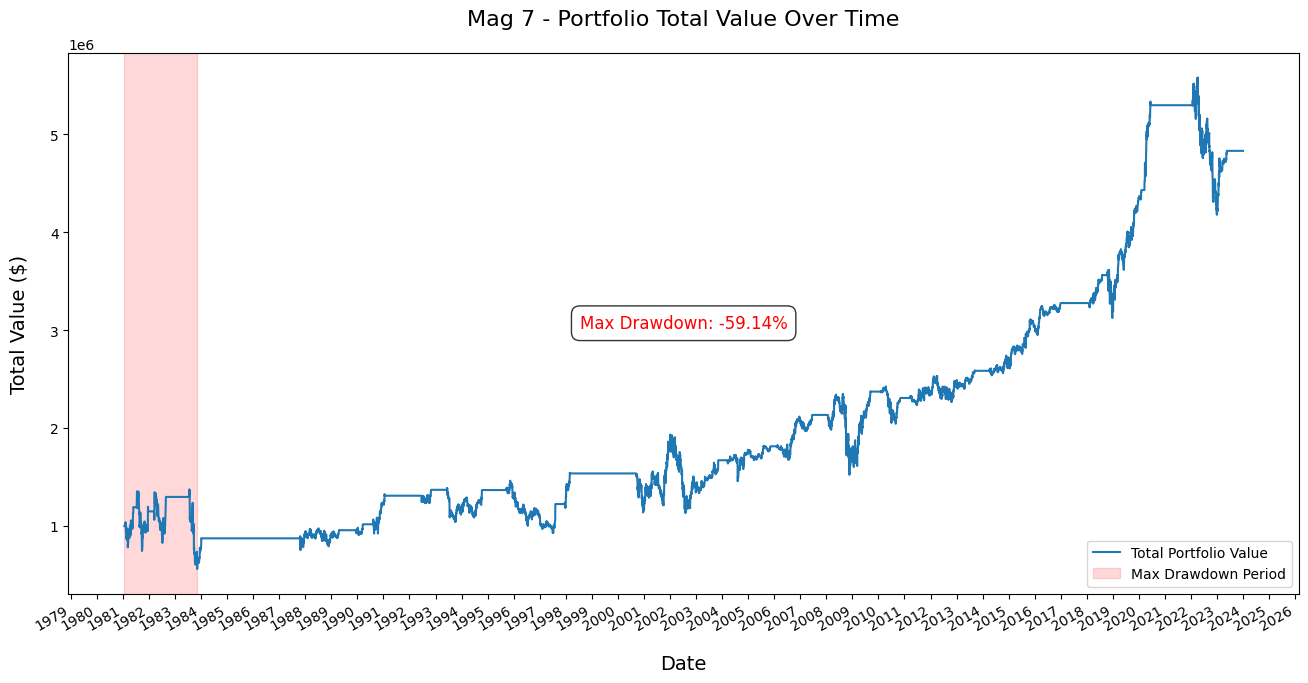

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(stocks, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {} # store each ticker's prices in dictionary
    stock_actions = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
        # Ensure index is datetime without timezone
        stock_data.index = pd.to_datetime(stock_data.index).tz_localize(None)
        stock_actions[stock] = ticker.actions
        # Convert datetime to date
        # stock_data.reset_index(inplace=True)
        # stock_data['Date'] = stock_data['Date'].dt.date
        # stock_data.set_index('Date', inplace=True)
        # stock_data.index = pd.to_datetime(stock_data.index)
        
        # Create ticker:data pairs
        if not stock_data.empty:
            data[stock] = stock_data[['Open', 'Close']]
        else:
            print(f"No data available for {stock} from {start_date}")
        
    return data, stock_actions


# Calculate RSI
def calculate_rsi(data, window=14):
    """
    Compute Wilder's Relative Strength Index (RSI) using the `.ewm()` method.
    Parameters:
        data (DataFrame): DataFrame containing a 'Close' column.
        window (int): Look-back period for RSI calculation (default: 14).
    Returns:
        DataFrame: DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0) # postive or zero
    loss = -delta.where(delta < 0, 0) # negative or zero

    # Use `.ewm()` for Wilder's smoothing
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.dropna(subset=['RSI'], inplace=True)
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] > 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] < 75), 'Signal'] = -1
    
    # Shift signals forward by one day for next-day execution
    data['Signal'] = data['Signal'].shift(1)
    
    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

def calculate_max_drawdown(portfolio_value):
    """
    Calculate the maximum drawdown and the period it occurs during.
    
    Parameters:
    portfolio_value (pd.Series): Portfolio values over time.

    Returns:
    max_drawdown (float): Maximum drawdown as a percentage.
    drawdown_start_date (datetime): Date when the max drawdown period starts.
    drawdown_end_date (datetime): Date when the max drawdown period ends.
    """
    # Calculate the running maximum portfolio value
    running_max = portfolio_value.cummax()
    
    # Calculate drawdown
    drawdown = (portfolio_value - running_max) / running_max

    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    # Find the start and end date of the max drawdown period
    drawdown_start_date = drawdown[drawdown == 0].index[0]  # first peak
    drawdown_end_date = drawdown.idxmin()  # date of max drawdown
    
    return max_drawdown, drawdown_start_date, drawdown_end_date

def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and considering different stock IPO dates.
    """
   
    # Create a combined index of all stock data
    common_index = pd.Index([])
    for ticker_data in data.values():
        common_index = common_index.union(ticker_data.index)
    common_index = sorted(common_index)

    # Prepare portfolio tracking
    portfolio = pd.DataFrame(index=common_index)
    portfolio['Cash'] = 0
    portfolio['Equity'] = 0
    portfolio['Stock Count'] = 0  
    holdings = {ticker: 0 for ticker in data.keys()} 
    
    # Initialize metrics tracking
    initial_value = initial_capital
    total_trades = 0
    
    # Verbose trading information
    trade_log = []
    
    # Track rebalancing dates
    rebalancing_dates = []
    
    # Initialize a list to store rebalancing actions
    pending_rebalancing = []
    
    # Backtesting loop over trading days
    for i, date in enumerate(portfolio.index):
        print(f"~ {date.strftime('%Y-%m-%d')} ~")
        # Initialize or carry forward cash
        if i == 0:
            cash = initial_capital
        else:
            cash = portfolio.at[portfolio.index[i - 1], 'Cash'] # Directly pulls the cash value from the previous row in the portfolio DataFrame

        equity_value = 0
        active_stocks = []
        
        # Step 1: Execute pending rebalancing actions from the previous day
        if pending_rebalancing:
            print(f"    * Executing rebalancing actions for {date.strftime('%Y-%m-%d')}")
            for action in pending_rebalancing:
                ticker = action['ticker']
                shares_to_sell = action['shares_to_sell']
                if date in data[ticker].index:  # Ensure the date is valid for the stock
                    open_price = data[ticker].loc[date, 'Open']
                    trade_value = shares_to_sell * open_price * (1 - commission - slippage)
                    holdings[ticker] -= shares_to_sell
                    cash += trade_value
                    print(f"        Rebalanced: Sold {shares_to_sell} shares of {ticker} at {open_price:.3f}")
                    print(f"        New Cash After Rebalance: {cash:.3f}")

            # Clear pending rebalancing actions after execution
            pending_rebalancing = []

        # Process each stock for each trading day
        for ticker, stock_data in data.items():
            # Skip stocks not yet active on this date
            if date not in stock_data.index:
                continue

            row = stock_data.loc[date]
            signal = row['Signal']
            open_price = row['Open']
            close_price = row['Close']
            
            
            # Track stock as active
            active_stocks.append(ticker)

            # Buy Logic
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                
                # Sanity check
                if open_price <= 0 or open_price > 10_000:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                if len(active_stocks) == 0:
                    print(f"No active stocks on {date}")
                    continue
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                cash_allocation = cash / len(active_stocks)
                shares_to_buy = max(min_shares, int(cash_allocation / (open_price * (1 + commission + slippage)))) #  Calculate the number of shares (shares_to_buy) accounting for fees upfront, ensuring that the total trade cost (including fees) fits within the available cash allocation.
                trade_cost = open_price * shares_to_buy * (1 + commission + slippage)
                
                # Logging Buy Signal
                print(f"    * Buy: {date.strftime('%Y-%m-%d')} - {ticker} - Shares: {shares_to_buy} @ {open_price:.3f}, Buy Cost: {trade_cost:.3f}, Cash Before: {cash:.3f}")
                
                if trade_cost <= cash:
                    holdings[ticker] += shares_to_buy
                    cash -= trade_cost
                    total_trades += 1
                    trade_log.append({
                            'date': date,
                            'ticker': ticker,
                            'action': 'BUY',
                            'shares': shares_to_buy,
                            'price': open_price
                        })
                    print(f"        Logged BUY: {trade_log[-1]}")
                    print(f"        BOUGHT: {date.strftime('%Y-%m-%d')} - {ticker} - Cash After: {cash:.3f}, Holdings: {holdings[ticker]}")

            # Sell Logic
            elif signal == -1 and holdings[ticker] > 0:
                
                # Sanity Check
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                shares_to_sell = holdings[ticker]
                sell_value = open_price * shares_to_sell * (1 - commission - slippage)
                
                # Logging Sell Signal
                print(f"    * SELL: {date.strftime('%Y-%m-%d')} - {ticker} - Shares: {shares_to_sell} @ {open_price:3f}, Sell Value: {sell_value:.3f}, Cash Before: {cash:.3f}")
                
                cash += sell_value
                holdings[ticker] = 0
                total_trades += 1
                trade_log.append({
                    'date': date,
                    'ticker': ticker,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': open_price
                })
                print(f"        Logged SELL: {trade_log[-1]}")
                print(f"        SOLD: {date.strftime('%Y-%m-%d')} - {ticker} - Holdings: {holdings[ticker]} - Cash After: {cash:.3f}")

            # Calculate stock's equity contribution
            equity_value += holdings[ticker] * close_price

        total_value = cash + equity_value
        
        # End-of-Day Portfolio Value Update
        portfolio.at[date, 'Cash'] = cash
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)
        
        
        # Display end of day portfolio allocation
        print(f"    ^ {date.strftime('%Y-%m-%d')} End of Day Portfolio Allocation - Portfolio Total Value: {total_value:.3f}, Equity:{equity_value:.3f}, Cash:{cash:.3f}")               
        for ticker in active_stocks:
            current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
            print(f"        {ticker}: {holdings[ticker]} shares, Value: {current_value:.3f}")
        
        # Rebalancing Check at End of Day
        if active_stocks:
            print(f"    # End of Day Check for Rebalancing: {date.strftime('%Y-%m-%d')}")
            # Check if stocks's current value exceeds 130% of target value at the end of day price
            target_value = total_value / len(active_stocks)
            for ticker in active_stocks:
                current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                if current_value > target_value * 1.3:
                    excess_value = current_value - target_value * 1.3
                    shares_to_sell = int(excess_value / data[ticker].loc[date, 'Close'])
                    # Ensure a minimum number of shares is considered for rebalancing
                    if excess_value > 0 and shares_to_sell >= min_shares:
                        pending_rebalancing.append({
                            'ticker': ticker,
                            'shares_to_sell': shares_to_sell,
                            'excess_value': excess_value,
                            'date_to_rebalance': date  # Track the current date for logging
                        })
                        print(f"        Rebalancing triggered for {ticker} on {date.strftime('%Y-%m-%d')}, Equity Value: {current_value:.3f}, Target Value: {target_value:.3f}, {shares_to_sell} shares to sell")
                
    
        
    

        
    # Calculate Max Drawdown
    max_drawdown, drawdown_start_date, drawdown_end_date = calculate_max_drawdown(portfolio['Total Value'])

    # Print Max Drawdown and its period
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"Max Drawdown Period: {drawdown_start_date} to {drawdown_end_date}")
    
    final_value = portfolio.iloc[-1]['Total Value']
    
    # Print out trade log for debugging
    print("\nTrade Log Summary:")
    buy_trades = [t for t in trade_log if t['action'] == 'BUY']
    sell_trades = [t for t in trade_log if t['action'] == 'SELL']
    print(f"Total Trades: {total_trades}")
    print(f"Buy Trades: {len(buy_trades)}")
    print(f"Sell Trades: {len(sell_trades)}")
    
    # Detailed buy and sell examples
    if buy_trades:
        print("\nSample Buy Trades:")
        for trade in buy_trades[:3]:
            print(f"{trade['date']}: Bought {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    if sell_trades:
        print("\nSample Sell Trades:")
        for trade in sell_trades[:3]:
            print(f"{trade['date']}: Sold {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    print(f"Initial Value: {initial_value}, Final Value: {final_value}")

    return portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown


# Performance metrics
def calculate_metrics(portfolio, trade_log, total_trades, initial_value, final_value):
    """Calculate performance metrics."""
    # Total Return
    total_return = (final_value - initial_value) / initial_value
    
    # Annualized Return
    total_days = len(portfolio)
    annual_return = (1 + total_return) ** (252 / total_days) - 1
    
    # Annualized Volatility
    returns = portfolio['Total Value'].pct_change().dropna()
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility if annual_volatility > 0 else 0

    # Maximum Drawdown: represents the largest percentage drop in the value of an investment from its peak to its trough over a given period.
    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio
    downside_std = (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))
    sortino_ratio = (annual_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0

    
    # Calculate trade returns and win rate
    trade_returns = []
    winning_trades = 0
    
    buy_trades = {}
    for trade in trade_log:
        print(trade)
        if trade['action'] == 'BUY':
            buy_trades[trade['ticker']] = trade
        elif trade['action'] == 'SELL':
            if trade['ticker'] in buy_trades:
                buy_trade = buy_trades.pop(trade['ticker'])
                trade_return = (trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
                if trade_return > 0:
                    winning_trades += 1

    # Calculate metrics
    average_return_per_trade = np.mean(trade_returns) if trade_returns else 0
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    expectancy = np.mean(trade_returns) if trade_returns else 0
    print(f"Average Return per Trade (calculated): {average_return_per_trade}")
    print(f"Total Return (calculated): {total_return}")
    
    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Total Number of Trades": total_trades,
        "Average Return per Trade": average_return_per_trade,
        "Win Rate": win_rate,
        "Expectancy": expectancy,
    }
    return metrics

def calculate_monthly_contributions_with_trading(portfolio, data):
    """
    Calculate monthly contributions of each stock to the portfolio's return, accounting for trading activity.
    
    Args:
    - portfolio (pd.DataFrame): Portfolio DataFrame containing 'Total Value', cash, and holdings.
    - data (dict): Dictionary of stock DataFrames, each containing 'Close' prices.
    
    Returns:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Contribution of each stock to the portfolio's return.
    """
    # Ensure the portfolio index is datetime
    portfolio.index = pd.to_datetime(portfolio.index, errors='coerce')
    portfolio = portfolio.dropna()  # Drop rows where index is NaT
    
    # Create 'Month' column and calculate portfolio monthly returns
    portfolio['Month'] = portfolio.index.to_period('M')
    portfolio_monthly_returns = portfolio.groupby('Month')['Total Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
    
    # Calculate stock contributions for each month
    stock_contributions = {}
    for month, group in portfolio.groupby('Month'):
        stock_contributions[month] = {}
        
        for ticker, df in data.items():
            # Ensure index is datetime
            df.index = pd.to_datetime(df.index, errors='coerce')
            
            # Check if the stock was active in the portfolio during this month
            if f'{ticker}_Holdings' not in group.columns:
                continue
            
            # Get holdings, start and end prices
            start_holdings = group[f'{ticker}_Holdings'].iloc[0]
            end_holdings = group[f'{ticker}_Holdings'].iloc[-1]
            start_price = df.loc[group.index[0], 'Close']
            end_price = df.loc[group.index[-1], 'Close']
            
            # Calculate realized contribution
            trades = group[f'{ticker}_Trades'] if f'{ticker}_Trades' in group.columns else []
            realized_gain = sum(
                trade['shares'] * (trade['price'] - start_price)
                for trade in trades if trade['action'] == 'SELL'
            )
            
            # Calculate unrealized contribution
            unrealized_gain = end_holdings * (end_price - start_price)
            
            # Total contribution
            total_contribution = realized_gain + unrealized_gain
            stock_contributions[month][ticker] = total_contribution / group['Total Value'].iloc[0]
    
    return portfolio_monthly_returns, stock_contributions


def find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions):
    """
    Identify the month with the highest portfolio return and the stock contributing most to that return.
    
    Args:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Weighted contributions of each stock to the portfolio's return.
    
    Returns:
    - result (dict): Dictionary with top month, portfolio return, and top stock contribution.
    """
    # Find the month with the highest portfolio return
    top_month = portfolio_monthly_returns.idxmax()
    top_month_return = portfolio_monthly_returns.max()

    # Find the stock with the highest contribution in the top month
    top_month_contributions = stock_contributions.get(top_month, {})
    if not top_month_contributions:
        print(f"Warning: No stock contributions for {top_month}.")
        return {
            "Top Month": top_month,
            "Top Month Return": top_month_return,
            "Top Stock": None,
            "Top Stock Contribution": None
        }

    top_stock = max(top_month_contributions, key=top_month_contributions.get)
    top_stock_contribution = top_month_contributions[top_stock]

    return {
        "Top Month": top_month,
        "Top Month Return": top_month_return,
        "Top Stock": top_stock,
        "Top Stock Contribution": top_stock_contribution
    }

# Fetch stock data
stock_data, stock_actions = fetch_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate RSI and generate signals for each stock
for ticker, data in stock_data.items():
    stock_data[ticker] = calculate_rsi(data)
    stock_data[ticker] = generate_signals(stock_data[ticker])

# Backtest
portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown= backtest(
    stock_data, 
    INITIAL_CAPITAL, 
    COMMISSION, 
    SLIPPAGE, 
    MIN_SHARES
)

metrics = calculate_metrics(
    portfolio, 
    trade_log,
    total_trades, 
    initial_value, 
    final_value
)

print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}" if isinstance(value, float) else f"{key}: {value}")

# # Which month did the portfolio have the highest return, and which stock contributed the most to that return?
# portfolio_monthly_returns, stock_contributions = calculate_monthly_contributions_with_trading(portfolio, data)
# result = find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions)

# # Print Results
# if result["Top Stock"]:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print(f"Stock contributing most: {result['Top Stock']} ({result['Top Stock Contribution']:.2%})")
# else:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print("No stock contributed to this return.")

# Plotting Portfolio
def visualize_portfolio_performance(portfolio, rebalancing_dates, max_drawdown, drawdown_start_date, drawdown_end_date):
    # Plot the portfolio total value
    plt.figure(figsize=(14, 8)) 
    plt.plot(portfolio.index, portfolio['Total Value'], label="Total Portfolio Value")

    # Highlight the Max Drawdown period
    plt.axvspan(drawdown_start_date, drawdown_end_date, color='red', alpha=0.15, label='Max Drawdown Period')

    # Highlight Rebalancing Events
    # Add rebalancing markers (only label it once)
    rebalance_legend_added = False
    for rebalance_date in rebalancing_dates:
        # Mark the rebalancing events with a vertical dashed line
        plt.axvline(rebalance_date, color='green', linestyle='--', linewidth=0.5, label='Rebalancing' if not rebalance_legend_added else "")
        rebalance_legend_added = True  # Set flag to avoid multiple "Rebalancing" legend entries

        
    # Add text annotations for Max Drawdown details
    plt.annotate(f'Max Drawdown: {max_drawdown*100:.2f}%', 
                xy=(0.5, 0.5), 
                xycoords='axes fraction', 
                horizontalalignment='center', 
                verticalalignment='center', 
                fontsize=12, 
                color='red', 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Add titles and labels
    plt.title('Mag 7 - Portfolio Total Value Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=14, labelpad=15)
    plt.ylabel('Total Value ($)', fontsize=14, labelpad=15)
    plt.tight_layout(pad=4.0) # increases the space between elements (e.g., titles, axis labels, and plot area).

    # Add date formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set x-axis to display years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()  # Rotate the date labels for better visibility

    # Show the plot
    plt.legend()
    plt.show()
    
visualize_portfolio_performance(
    portfolio=portfolio, 
    rebalancing_dates=rebalancing_dates, 
    drawdown_start_date=drawdown_start_date, 
    drawdown_end_date=drawdown_end_date, 
    max_drawdown=max_drawdown
)


In [5]:
pd.set_option('display.width', 1000)
stock_data['MSFT'].loc['1990-08-05':'1990-08-10']

Open     Close        RSI  Signal
Date                                             
1990-08-06  0.525622  0.517075  24.757715     0.0
1990-08-07  0.523485  0.523485  27.539744     1.0
1990-08-08  0.534169  0.542715  35.272359     0.0
1990-08-09  0.546989  0.556604  40.233196     0.0
1990-08-10  0.556604  0.551262  38.995201     0.0

In [15]:
portfolio.loc['1981-02-21':'1990-02-25']

Cash         Equity  Stock Count    Total Value
1981-02-23       0.068517  890332.923112            1  890332.991629
1981-02-24       0.068517  858698.859111            1  858698.927628
1981-02-25       0.068517  912928.772667            1  912928.841184
1981-02-26       0.068517  926486.329417            1  926486.397934
1981-02-27       0.068517  958128.777952            1  958128.846469
...                   ...            ...          ...            ...
1990-02-16  478843.790802  449821.123578            2  928664.914380
1990-02-20  478843.790802  446489.483471            2  925333.274273
1990-02-21  478843.790802  453152.876213            2  931996.667015
1990-02-22  478843.790802  439825.612487            2  918669.403289
1990-02-23  478843.790802  443157.505781            2  922001.296583

[2278 rows x 4 columns]

### V4: End of month rebalancing

~ 1981-01-21 ~
    ^ 1981-01-21 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
~ 1981-01-22 ~
    ^ 1981-01-22 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
~ 1981-01-23 ~
    ^ 1981-01-23 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
~ 1981-01-26 ~
    ^ 1981-01-26 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
~ 1981-01-27 ~
    ^ 1981-01-27 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 shares, Value: 0.000
~ 1981-01-28 ~
    ^ 1981-01-28 End of Day Portfolio Allocation - Portfolio Total Value: 1000000.000, Equity:0.000, Cash:1000000.000
        AAPL: 0 s

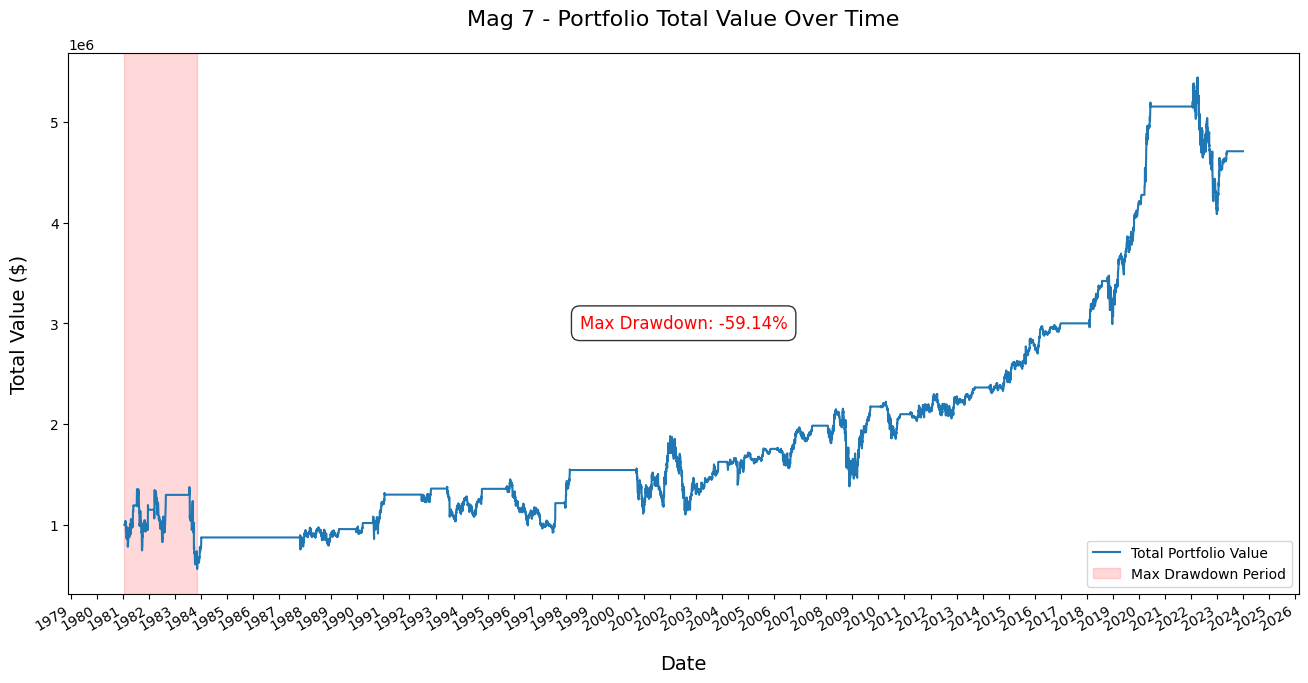

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants
INITIAL_CAPITAL = 1_000_000
COMMISSION = 0.001  # 0.10%
SLIPPAGE = 0.0002   # 0.02%
MIN_SHARES = 10
RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252

STOCKS = ["MSFT", "AAPL", "NVDA", "AMZN", "GOOG", "META", "TSLA"]
START_DATE = "1981-01-01"
END_DATE = "2023-12-31"

# Fetch historical data
def fetch_stock_data(stocks, start_date, end_date):
    """Fetch adjusted historical stock data from Yahoo Finance."""
    data = {} # store each ticker's prices in dictionary
    stock_actions = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
        # Ensure index is datetime without timezone
        stock_data.index = pd.to_datetime(stock_data.index).tz_localize(None)
        stock_actions[stock] = ticker.actions
        # Convert datetime to date
        # stock_data.reset_index(inplace=True)
        # stock_data['Date'] = stock_data['Date'].dt.date
        # stock_data.set_index('Date', inplace=True)
        # stock_data.index = pd.to_datetime(stock_data.index)
        
        # Create ticker:data pairs
        if not stock_data.empty:
            data[stock] = stock_data[['Open', 'Close']]
        else:
            print(f"No data available for {stock} from {start_date}")
        
    return data, stock_actions


# Calculate RSI
def calculate_rsi(data, window=14):
    """
    Compute Wilder's Relative Strength Index (RSI) using the `.ewm()` method.
    Parameters:
        data (DataFrame): DataFrame containing a 'Close' column.
        window (int): Look-back period for RSI calculation (default: 14).
    Returns:
        DataFrame: DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = data['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0) # postive or zero
    loss = -delta.where(delta < 0, 0) # negative or zero

    # Use `.ewm()` for Wilder's smoothing
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    # Calculate Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.dropna(subset=['RSI'], inplace=True)
    return data

def generate_signals(data):
    """
    Generate buy/sell signals based on RSI crossover strategy.
    Buy: RSI crosses from above 25 to below 25.
    Sell: RSI crosses from below 75 to above 75.
    """
    data['Signal'] = 0
    data['Prev_RSI'] = data['RSI'].shift(1)

    # Buy Signal: RSI crosses below 25
    data.loc[(data['RSI'] < 25) & (data['Prev_RSI'] > 25), 'Signal'] = 1

    # Sell Signal: RSI crosses above 75
    data.loc[(data['RSI'] > 75) & (data['Prev_RSI'] < 75), 'Signal'] = -1
    
    # Shift signals forward by one day for next-day execution
    data['Signal'] = data['Signal'].shift(1)
    
    # Drop helper column (optional)
    data.drop(columns=['Prev_RSI'], inplace=True)
    
    return data

def calculate_max_drawdown(portfolio_value):
    """
    Calculate the maximum drawdown and the period it occurs during.
    
    Parameters:
    portfolio_value (pd.Series): Portfolio values over time.

    Returns:
    max_drawdown (float): Maximum drawdown as a percentage.
    drawdown_start_date (datetime): Date when the max drawdown period starts.
    drawdown_end_date (datetime): Date when the max drawdown period ends.
    """
    # Calculate the running maximum portfolio value
    running_max = portfolio_value.cummax()
    
    # Calculate drawdown
    drawdown = (portfolio_value - running_max) / running_max

    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    # Find the start and end date of the max drawdown period
    drawdown_start_date = drawdown[drawdown == 0].index[0]  # first peak
    drawdown_end_date = drawdown.idxmin()  # date of max drawdown
    
    return max_drawdown, drawdown_start_date, drawdown_end_date

def is_last_trading_day_of_month(date, portfolio):
    """
    Scenario 1: If your dataset ends on 2024-12-28, the function will not trigger rebalancing on 2024-12-28. 
    It will wait until 2024-12-31, even if 2024-12-31 is not in the dataset.

    Scenario 2: If 2024-12-31 is the last trading day in the dataset, 
    the function will correctly identify it as the last trading day of the month and trigger rebalancing.
    """
    
    # Get the next trading day index
    next_date_index = portfolio.index.get_loc(date) + 1
    
    # Handling No Next Trading Day
    if next_date_index >= len(portfolio.index):
        # Check if the current date is the last day of the month
        # We wait for the actual last day of the calendar month (e.g., 2024-12-31)
        last_day_of_month = pd.to_datetime(f'{date.year}-{date.month:02d}-01') + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        return date == last_day_of_month
    
    # next_date exist
    next_date = portfolio.index[next_date_index]
    
    # Check if the next date is in the next month, meaning current date is the last trading day of the month
    return next_date.month != date.month

def backtest(data, initial_capital, commission, slippage, min_shares):
    """
    Simulate backtesting with portfolio rebalancing and considering different stock IPO dates.
    """
   
    # Create a combined index of all stock data
    common_index = pd.Index([])
    for ticker_data in data.values():
        common_index = common_index.union(ticker_data.index)
    common_index = sorted(common_index)

    # Prepare portfolio tracking
    portfolio = pd.DataFrame(index=common_index)
    portfolio['Cash'] = 0
    portfolio['Equity'] = 0
    portfolio['Stock Count'] = 0  
    holdings = {ticker: 0 for ticker in data.keys()} 
    
    # Initialize metrics tracking
    initial_value = initial_capital
    total_trades = 0
    
    # Verbose trading information
    trade_log = []
    
    # Track rebalancing dates
    rebalancing_dates = []
    
    # Initialize a list to store rebalancing actions
    pending_rebalancing = []
    
    # Backtesting loop over trading days
    for i, date in enumerate(portfolio.index):
        print(f"~ {date.strftime('%Y-%m-%d')} ~")
        # Initialize or carry forward cash
        if i == 0:
            cash = initial_capital
        else:
            cash = portfolio.at[portfolio.index[i - 1], 'Cash'] # Directly pulls the cash value from the previous date in the portfolio DataFrame

        equity_value = 0 # Reset total equity_value because the prices for each stock has changed as market opens, to be calculated later at the EOD
        active_stocks = []
    
        # Step 1: Execute pending rebalancing actions from the previous day
        if pending_rebalancing:
            print(f"    * Executing rebalancing actions for {date.strftime('%Y-%m-%d')}")
            for action in pending_rebalancing:
                ticker = action['ticker']
                shares_to_sell = action['shares_to_sell']
                if date in data[ticker].index:  # Ensure the date is valid for the stock
                    open_price = data[ticker].loc[date, 'Open']
                    trade_value = shares_to_sell * open_price * (1 - commission - slippage)
                    holdings[ticker] -= shares_to_sell
                    cash += trade_value
                    total_trades += 1
                    trade_log.append({
                        'date': date,
                        'ticker': ticker,
                        'action': 'SELL',
                        'shares': shares_to_sell,
                        'price': open_price
                    })
                    print(f"        Rebalanced: Sold {shares_to_sell} shares of {ticker} at {open_price:.3f}")
                    print(f"        New Cash After Rebalance: {cash:.3f}")

            # Clear pending rebalancing actions after execution
            pending_rebalancing = []

        # Process each stock for each trading day
        for ticker, stock_data in data.items():
            # Skip stocks not yet active on this date
            if date not in stock_data.index:
                continue # skip the remaining code for the current iteration and move on to the next iteration(ticker) of the loop.

            row = stock_data.loc[date]
            signal = row['Signal']
            open_price = row['Open']
            close_price = row['Close']
            
            
            # Track ticker as active 
            active_stocks.append(ticker)

            # Buy Logic
            if signal == 1 and holdings[ticker] < min_shares:  # Buy
                
                # Sanity check
                if open_price <= 0 or open_price > 10_000:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                if len(active_stocks) == 0:
                    print(f"No active stocks on {date}")
                    continue
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                cash_allocation = cash / len(active_stocks)
                shares_to_buy = max(min_shares, int(cash_allocation / (open_price * (1 + commission + slippage)))) #  Calculate the number of shares (shares_to_buy) accounting for fees upfront, ensuring that the total trade cost (including fees) fits within the available cash allocation.
                trade_cost = open_price * shares_to_buy * (1 + commission + slippage)
                
                # Logging Buy Signal
                print(f"    * Buy: {date.strftime('%Y-%m-%d')} - {ticker} - Shares: {shares_to_buy} @ {open_price:.3f}, Buy Cost: {trade_cost:.3f}, Cash Before: {cash:.3f}")
                
                if trade_cost <= cash:
                    holdings[ticker] += shares_to_buy
                    cash -= trade_cost
                    total_trades += 1
                    trade_log.append({
                            'date': date,
                            'ticker': ticker,
                            'action': 'BUY',
                            'shares': shares_to_buy,
                            'price': open_price
                        })
                    print(f"        Logged BUY: {trade_log[-1]}")
                    print(f"        BOUGHT: {date.strftime('%Y-%m-%d')} - {ticker} - Cash After: {cash:.3f}, Holdings: {holdings[ticker]}")

            # Sell Logic
            elif signal == -1 and holdings[ticker] > 0:
                
                # Sanity Check
                if open_price <= 0:
                    print(f"Invalid open price for {ticker} on {date}: {open_price}")
                    continue
                
                shares_to_sell = holdings[ticker]
                sell_value = open_price * shares_to_sell * (1 - commission - slippage)
                
                # Logging Sell Signal
                print(f"    * SELL: {date.strftime('%Y-%m-%d')} - {ticker} - Shares: {shares_to_sell} @ {open_price:3f}, Sell Value: {sell_value:.3f}, Cash Before: {cash:.3f}")
                
                cash += sell_value
                holdings[ticker] = 0
                total_trades += 1
                trade_log.append({
                    'date': date,
                    'ticker': ticker,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': open_price
                })
                print(f"        Logged SELL: {trade_log[-1]}")
                print(f"        SOLD: {date.strftime('%Y-%m-%d')} - {ticker} - Holdings: {holdings[ticker]} - Cash After: {cash:.3f}")

            # Add each stock's equity contribution to total equity_value of portfolio
            equity_value += holdings[ticker] * close_price

        #
        total_value = cash + equity_value
        
        # End-of-Day Portfolio Value Update
        portfolio.at[date, 'Cash'] = cash
        portfolio.at[date, 'Equity'] = equity_value
        portfolio.at[date, 'Total Value'] = total_value
        portfolio.at[date, 'Stock Count'] = len(active_stocks)
        
        
        # Display end of day portfolio allocation
        print(f"    ^ {date.strftime('%Y-%m-%d')} End of Day Portfolio Allocation - Portfolio Total Value: {total_value:.3f}, Equity:{equity_value:.3f}, Cash:{cash:.3f}")               
        for ticker in active_stocks:
            current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
            print(f"        {ticker}: {holdings[ticker]} shares, Value: {current_value:.3f}")
        
            
        # Rebalancing Check at End of Day
        if active_stocks and is_last_trading_day_of_month(date, portfolio):
            print(f"### End of Month Check for Rebalancing: {date.strftime('%Y-%m-%d')}")
            # Check if stocks's current value exceeds 130% of target value at the end of day price
            target_value = total_value / len(active_stocks)
            
            for ticker in active_stocks:
                current_value = holdings[ticker] * data[ticker].loc[date, 'Close']
                
                if current_value > target_value * 1.3:
                    excess_value = current_value - target_value * 1.3
                    shares_to_sell = int(excess_value / data[ticker].loc[date, 'Close'])
                    
                    # Ensure a minimum number of shares is considered for rebalancing
                    if excess_value > 0 and shares_to_sell >= min_shares:
                        pending_rebalancing.append({
                            'ticker': ticker,
                            'shares_to_sell': shares_to_sell,
                            'excess_value': excess_value,
                            'date_to_rebalance': date  # Track the current date for logging
                        })
                        print(f"    Rebalancing triggered for {ticker} on {date.strftime('%Y-%m-%d')}, Equity Value: {current_value:.3f}, Target Value: {target_value:.3f}, {shares_to_sell} shares to sell \n")
            

            if not pending_rebalancing:
                print(f"    No rebalancing required \n")
                print()
    
        
    

        
    # Calculate Max Drawdown
    max_drawdown, drawdown_start_date, drawdown_end_date = calculate_max_drawdown(portfolio['Total Value'])

    # Print Max Drawdown and its period
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"Max Drawdown Period: {drawdown_start_date} to {drawdown_end_date}")
    
    final_value = portfolio.iloc[-1]['Total Value']
    
    # Print out trade log for debugging
    print("\nTrade Log Summary:")
    buy_trades = [t for t in trade_log if t['action'] == 'BUY']
    sell_trades = [t for t in trade_log if t['action'] == 'SELL']
    print(f"Total Trades: {total_trades}")
    print(f"Buy Trades: {len(buy_trades)}")
    print(f"Sell Trades: {len(sell_trades)}")
    
    # Detailed buy and sell examples
    if buy_trades:
        print("\nSample Buy Trades:")
        for trade in buy_trades[:3]:
            print(f"{trade['date']}: Bought {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    if sell_trades:
        print("\nSample Sell Trades:")
        for trade in sell_trades[:3]:
            print(f"{trade['date']}: Sold {trade['shares']} shares of {trade['ticker']} at {trade['price']}")
    
    print(f"Initial Value: {initial_value}, Final Value: {final_value}")

    return portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown


# Performance metrics
def calculate_metrics(portfolio, trade_log, total_trades, initial_value, final_value):
    """Calculate performance metrics."""
    # Total Return
    total_return = (final_value - initial_value) / initial_value
    
    # Annualized Return
    total_days = len(portfolio)
    annual_return = (1 + total_return) ** (252 / total_days) - 1
    
    # Annualized Volatility
    returns = portfolio['Total Value'].pct_change().dropna()
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Sharpe Ratio
    sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility if annual_volatility > 0 else 0

    # Maximum Drawdown: represents the largest percentage drop in the value of an investment from its peak to its trough over a given period.
    cumulative_max = portfolio['Total Value'].cummax()
    drawdown = portfolio['Total Value'] / cumulative_max - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio
    downside_std = (returns[returns < 0].std() * np.sqrt(TRADING_DAYS_PER_YEAR))
    sortino_ratio = (annual_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0

    
    # Calculate trade returns and win rate
    trade_returns = []
    winning_trades = 0
    
    buy_trades = {}
    for trade in trade_log:
        print(trade)
        if trade['action'] == 'BUY':
            buy_trades[trade['ticker']] = trade
        elif trade['action'] == 'SELL':
            if trade['ticker'] in buy_trades:
                buy_trade = buy_trades.pop(trade['ticker'])
                trade_return = (trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
                if trade_return > 0:
                    winning_trades += 1

    # Calculate metrics
    average_return_per_trade = np.mean(trade_returns) if trade_returns else 0
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    expectancy = np.mean(trade_returns) if trade_returns else 0
    print(f"Average Return per Trade (calculated): {average_return_per_trade}")
    print(f"Total Return (calculated): {total_return}")
    
    metrics = {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Total Number of Trades": total_trades,
        "Average Return per Trade": average_return_per_trade,
        "Win Rate": win_rate,
        "Expectancy": expectancy,
    }
    return metrics

def calculate_monthly_contributions_with_trading(portfolio, data):
    """
    Calculate monthly contributions of each stock to the portfolio's return, accounting for trading activity.
    
    Args:
    - portfolio (pd.DataFrame): Portfolio DataFrame containing 'Total Value', cash, and holdings.
    - data (dict): Dictionary of stock DataFrames, each containing 'Close' prices.
    
    Returns:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Contribution of each stock to the portfolio's return.
    """
    # Ensure the portfolio index is datetime
    portfolio.index = pd.to_datetime(portfolio.index, errors='coerce')
    portfolio = portfolio.dropna()  # Drop rows where index is NaT
    
    # Create 'Month' column and calculate portfolio monthly returns
    portfolio['Month'] = portfolio.index.to_period('M')
    portfolio_monthly_returns = portfolio.groupby('Month')['Total Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
    
    # Calculate stock contributions for each month
    stock_contributions = {}
    for month, group in portfolio.groupby('Month'):
        stock_contributions[month] = {}
        
        for ticker, df in data.items():
            # Ensure index is datetime
            df.index = pd.to_datetime(df.index, errors='coerce')
            
            # Check if the stock was active in the portfolio during this month
            if f'{ticker}_Holdings' not in group.columns:
                continue
            
            # Get holdings, start and end prices
            start_holdings = group[f'{ticker}_Holdings'].iloc[0]
            end_holdings = group[f'{ticker}_Holdings'].iloc[-1]
            start_price = df.loc[group.index[0], 'Close']
            end_price = df.loc[group.index[-1], 'Close']
            
            # Calculate realized contribution
            trades = group[f'{ticker}_Trades'] if f'{ticker}_Trades' in group.columns else []
            realized_gain = sum(
                trade['shares'] * (trade['price'] - start_price)
                for trade in trades if trade['action'] == 'SELL'
            )
            
            # Calculate unrealized contribution
            unrealized_gain = end_holdings * (end_price - start_price)
            
            # Total contribution
            total_contribution = realized_gain + unrealized_gain
            stock_contributions[month][ticker] = total_contribution / group['Total Value'].iloc[0]
    
    return portfolio_monthly_returns, stock_contributions


def find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions):
    """
    Identify the month with the highest portfolio return and the stock contributing most to that return.
    
    Args:
    - portfolio_monthly_returns (pd.Series): Monthly returns for the portfolio.
    - stock_contributions (dict): Weighted contributions of each stock to the portfolio's return.
    
    Returns:
    - result (dict): Dictionary with top month, portfolio return, and top stock contribution.
    """
    # Find the month with the highest portfolio return
    top_month = portfolio_monthly_returns.idxmax()
    top_month_return = portfolio_monthly_returns.max()

    # Find the stock with the highest contribution in the top month
    top_month_contributions = stock_contributions.get(top_month, {})
    if not top_month_contributions:
        print(f"Warning: No stock contributions for {top_month}.")
        return {
            "Top Month": top_month,
            "Top Month Return": top_month_return,
            "Top Stock": None,
            "Top Stock Contribution": None
        }

    top_stock = max(top_month_contributions, key=top_month_contributions.get)
    top_stock_contribution = top_month_contributions[top_stock]

    return {
        "Top Month": top_month,
        "Top Month Return": top_month_return,
        "Top Stock": top_stock,
        "Top Stock Contribution": top_stock_contribution
    }

# Fetch stock data
stock_data, stock_actions = fetch_stock_data(STOCKS, START_DATE, END_DATE)

# Calculate RSI and generate signals for each stock
for ticker, data in stock_data.items():
    stock_data[ticker] = calculate_rsi(data)
    stock_data[ticker] = generate_signals(stock_data[ticker])

# Backtest
portfolio, trade_log, total_trades, initial_value, final_value, rebalancing_dates, drawdown_start_date, drawdown_end_date, max_drawdown= backtest(
    stock_data, 
    INITIAL_CAPITAL, 
    COMMISSION, 
    SLIPPAGE, 
    MIN_SHARES
)

metrics = calculate_metrics(
    portfolio, 
    trade_log,
    total_trades, 
    initial_value, 
    final_value
)

print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}" if isinstance(value, float) else f"{key}: {value}")

# # Which month did the portfolio have the highest return, and which stock contributed the most to that return?
# portfolio_monthly_returns, stock_contributions = calculate_monthly_contributions_with_trading(portfolio, data)
# result = find_top_contributor_with_weights(portfolio_monthly_returns, stock_contributions)

# # Print Results
# if result["Top Stock"]:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print(f"Stock contributing most: {result['Top Stock']} ({result['Top Stock Contribution']:.2%})")
# else:
#     print(f"Month with highest return: {result['Top Month']} ({result['Top Month Return']:.2%})")
#     print("No stock contributed to this return.")

# Plotting Portfolio
def visualize_portfolio_performance(portfolio, rebalancing_dates, max_drawdown, drawdown_start_date, drawdown_end_date):
    # Plot the portfolio total value
    plt.figure(figsize=(14, 8)) 
    plt.plot(portfolio.index, portfolio['Total Value'], label="Total Portfolio Value")

    # Highlight the Max Drawdown period
    plt.axvspan(drawdown_start_date, drawdown_end_date, color='red', alpha=0.15, label='Max Drawdown Period')

    # Highlight Rebalancing Events
    # Add rebalancing markers (only label it once)
    rebalance_legend_added = False
    for rebalance_date in rebalancing_dates:
        # Mark the rebalancing events with a vertical dashed line
        plt.axvline(rebalance_date, color='green', linestyle='--', linewidth=0.5, label='Rebalancing' if not rebalance_legend_added else "")
        rebalance_legend_added = True  # Set flag to avoid multiple "Rebalancing" legend entries

        
    # Add text annotations for Max Drawdown details
    plt.annotate(f'Max Drawdown: {max_drawdown*100:.2f}%', 
                xy=(0.5, 0.5), 
                xycoords='axes fraction', 
                horizontalalignment='center', 
                verticalalignment='center', 
                fontsize=12, 
                color='red', 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Add titles and labels
    plt.title('Mag 7 - Portfolio Total Value Over Time', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=14, labelpad=15)
    plt.ylabel('Total Value ($)', fontsize=14, labelpad=15)
    plt.tight_layout(pad=4.0) # increases the space between elements (e.g., titles, axis labels, and plot area).

    # Add date formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set x-axis to display years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()  # Rotate the date labels for better visibility

    # Show the plot
    plt.legend()
    plt.show()
    
visualize_portfolio_performance(
    portfolio=portfolio, 
    rebalancing_dates=rebalancing_dates, 
    drawdown_start_date=drawdown_start_date, 
    drawdown_end_date=drawdown_end_date, 
    max_drawdown=max_drawdown
)
